<a href="https://colab.research.google.com/github/tbottelbergs/cv_copy/blob/master/CV_V0.0.5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer vision Final project

# Version History
## V0.0.1 
* One-hot encoding (based on first class)
* Predictions based on softmax (no extra hidden layer of MobileNetV2)
* Optimizer='rmsprop', Loss='categorical_crossentropy'
## V0.0.2
* Added extra hidden layer of 1024 nodes
* Accuracy never rises above 74% (depends on which class is selected as first class)
## V0.0.3
* Added multi-label targets
* Changed output layer to 'sigmoid' activation function
* Changed the loss function to tf.keras.losses.CategoricalCrossentropy(from_logits=True)
* Changed the metric to categorical_accuracy
## V0.0.4
* Changed loss function to tf.nn.sigmoid_cross_entropy_with_logits
-> doesn't make things better
## V0.0.5
* Using TruePositives, TrueNegatives, FalsePositives, FalseNegatives, TopKCategoricalAccuracy(k=1) as metric
* Added fine tuning of last 55 layers of the base model

Fetch data

In [0]:
import os
from skimage import io
from skimage.transform import resize
import numpy as np
import random
import tensorflow as tf
from xml.dom import minidom
import matplotlib.pyplot as plt

In [147]:
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xf VOCtrainval_11-May-2009.tar --totals



File ‘VOCtrainval_11-May-2009.tar’ already there; not retrieving.

Total bytes read: 935536640 (893MiB, 123MiB/s)


To keep in mind:
* In one image, multiple objects can appear (also of different classes)
* Every image has at least one object in it?

In [0]:
voc_root_folder = "/content/VOCdevkit/VOC2009"
imageNamesFile = os.path.join(voc_root_folder,'ImageSets','Main','trainval.txt')
imageNames = np.loadtxt(imageNamesFile, dtype='str')

In [0]:
np.random.seed(5)
random.seed(5)
np.random.shuffle(imageNames) # seed not working...
trainImageNames, validationImageNames, testImageNames = np.split(imageNames, [5000, 6000])

In [150]:
print(trainImageNames[4999]) # 2008_002718
print(validationImageNames[0]) # 2008_004659

2008_000085
2009_002571


In [151]:
CLASSES = ['aeroplane','bicycle','bird','boat','bottle', 'bus','car','cat','chair','cow', 'diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
class_to_idx = dict((c, i) for i, c in enumerate(CLASSES))
idx_to_class = dict((i, c) for i, c in enumerate(CLASSES))
def one_hot_encode(clss):
  encoded = [0 for _ in range(len(CLASSES))]
  for cls in clss:
    encoded[class_to_idx[cls]] = 1
  return encoded
def one_hot_decode(encoded):
  clss = [idx_to_class[idx] for idx, val in enumerate(encoded) if val == 1]
  return clss
a = one_hot_encode(['bicycle', 'bus', 'chair'])
print(a)
print(one_hot_decode(a))

[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['bicycle', 'bus', 'chair']


In [0]:
image_folder = os.path.join(voc_root_folder, "JPEGImages")
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def createDataSet(imageNames):
  images = []
  targets = []
  for imageName in imageNames:
    xmlFile = os.path.join(voc_root_folder,'Annotations',imageName + '.xml')
    xml = minidom.parse(xmlFile)
    objectsXml = xml.getElementsByTagName('object')
    objects = []
    image = resize(io.imread(os.path.join(image_folder,imageName + ".jpg")), IMG_SHAPE)
    for objectXml in objectsXml:
      object = objectXml.getElementsByTagName('name')[0].firstChild.nodeValue
      if object not in objects:
        objects.append(object)
    targets.append(one_hot_encode(objects))
    images.append(image)
  return (images,targets)

In [0]:
trainImages, trainTargets = createDataSet(trainImageNames)
validationImages, validationTargets = createDataSet(validationImageNames)

In [154]:
m = tf.keras.metrics.Sum()
m.update_state([1, 0, 0, 1])
print('Final result: ', m.result().numpy())

Final result:  2.0


In [155]:
m = tf.keras.metrics.TrueNegatives()
m.update_state([[0, 1, 0, 1],[0, 1, 0, 1]], [[0, 1, 0.6, 0.7],[1, 0, 0.6, 0.7]])
print('Final result: ', m.result().numpy()) 

Final result:  1.0


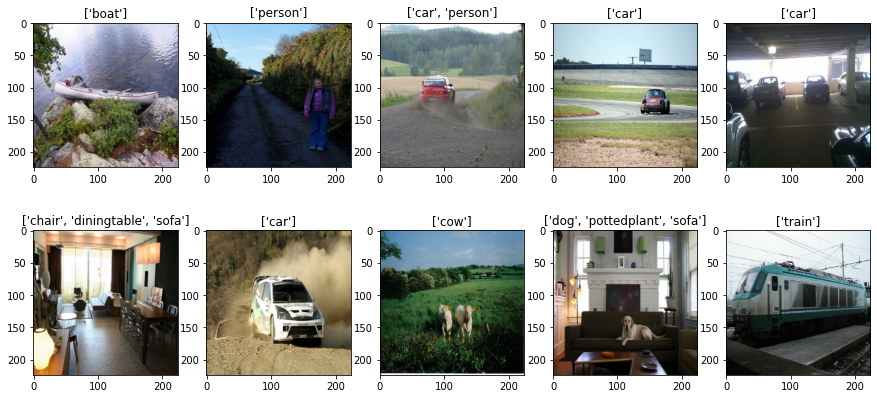

In [156]:
fig=plt.figure(figsize=(15, 7))
for i in range(1,6):
  idx = random.randint(0,len(trainImages))
  fig.add_subplot(2, 5, i)
  plt.imshow(trainImages[idx])
  plt.title(one_hot_decode(trainTargets[idx]))
for i in range(6,11):
  idx = random.randint(0,len(validationImages))
  fig.add_subplot(2, 5, i)
  plt.imshow(validationImages[idx])
  plt.title(one_hot_decode(validationTargets[idx]))

In [0]:
x_train = np.array(trainImages).astype('float32')
y_train = np.array(trainTargets)
x_val = np.array(validationImages).astype('float32')
y_val = np.array(validationTargets)

In [0]:
BATCH_SIZE = 100
train_batches = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE)
validation_batches = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

In [159]:
print(x_val.shape)

(1000, 224, 224, 3)


In [0]:

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [0]:
base_model.trainable = False

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
predictions = tf.keras.layers.Dense(20, activation='sigmoid')
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  tf.keras.layers.Dense(1024, activation='relu', name='hidden_layer'),
  predictions
])
model.compile(optimizer='rmsprop', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.Sum(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TopKCategoricalAccuracy(k=1)])

In [163]:
print(len(base_model.layers))

155


In [164]:
print(sum(sum(y_train)))
print(7355/7637)
print(y_train.shape)

7637
0.9630745056959539
(5000, 20)


In [165]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=validation_batches)

Epoch 1/10
50/50 [==============================] - 106s 2s/step - loss: 3.7899 - sum: 6688.9814 - true_positives_20: 6762.0000 - true_negatives_15: 73103.0000 - false_positives_2: 19260.0000 - false_negatives_2: 875.0000 - top_k_categorical_accuracy: 0.1614 - val_loss: 3.5270 - val_sum: 1382.9905 - val_true_positives_20: 1395.0000 - val_true_negatives_15: 15495.0000 - val_false_positives_2: 3028.0000 - val_false_negatives_2: 82.0000 - val_top_k_categorical_accuracy: 0.2430
Epoch 2/10
50/50 [==============================] - 105s 2s/step - loss: 3.5902 - sum: 7077.8472 - true_positives_20: 7130.0000 - true_negatives_15: 81254.0000 - false_positives_2: 11109.0000 - false_negatives_2: 507.0000 - top_k_categorical_accuracy: 0.2594 - val_loss: 3.5318 - val_sum: 1347.4102 - val_true_positives_20: 1353.0000 - val_true_negatives_15: 15799.0000 - val_false_positives_2: 2724.0000 - val_false_negatives_2: 124.0000 - val_top_k_categorical_accuracy: 0.4170
Epoch 3/10
50/50 [=======================

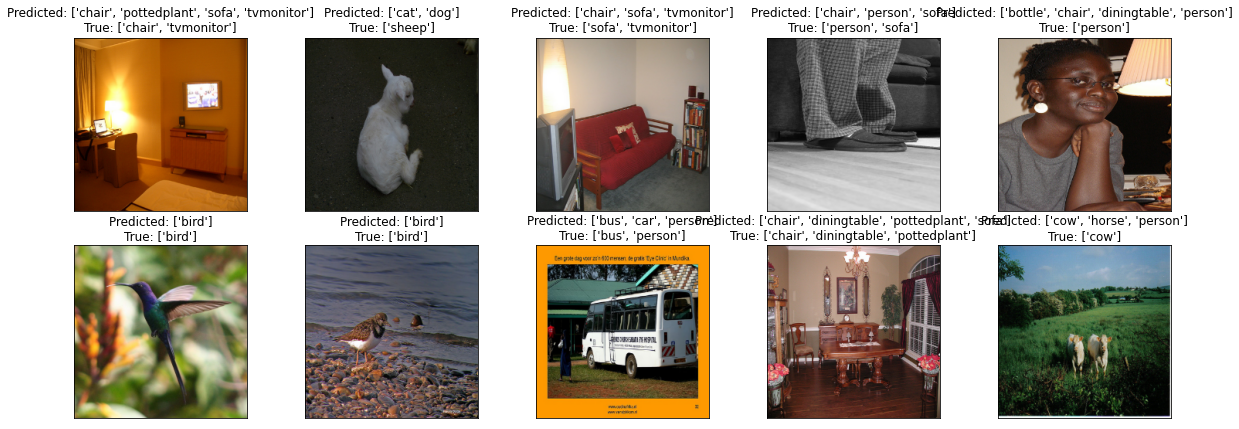

In [166]:
fig=plt.figure(figsize=(20, 7))
for i in range(1,6):
  idx = random.randint(0,len(x_train))
  fig.add_subplot(2, 5, i)
  plt.imshow(x_train[idx])
  y_pred = one_hot_decode(np.around(model(x_train[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_train[idx])))
  plt.xticks([])
  plt.yticks([])
for i in range(6,11):
  idx = random.randint(0,len(x_val))
  fig.add_subplot(2, 5, i)
  plt.imshow(x_val[idx])
  y_pred = one_hot_decode(np.around(model(x_val[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_val[idx])))
  plt.xticks([])
  plt.yticks([])

In [0]:
base_model.trainable = True
for layer in base_model.layers[:100]:
  layer.trainable =  False

In [0]:
model.compile(optimizer='rmsprop', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.Sum(), tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.TopKCategoricalAccuracy(k=1)])

In [169]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=validation_batches)

Epoch 1/10
50/50 [==============================] - 180s 4s/step - loss: 3.6979 - sum: 6763.1392 - true_positives_21: 6764.0000 - true_negatives_16: 78459.0000 - false_positives_3: 13904.0000 - false_negatives_3: 873.0000 - top_k_categorical_accuracy: 0.6956 - val_loss: 3.9967 - val_sum: 692.3312 - val_true_positives_21: 693.0000 - val_true_negatives_16: 16991.0000 - val_false_positives_3: 1532.0000 - val_false_negatives_3: 784.0000 - val_top_k_categorical_accuracy: 0.3470
Epoch 2/10
50/50 [==============================] - 179s 4s/step - loss: 3.6596 - sum: 6798.9243 - true_positives_21: 6798.0000 - true_negatives_16: 80394.0000 - false_positives_3: 11969.0000 - false_negatives_3: 839.0000 - top_k_categorical_accuracy: 0.7812 - val_loss: 3.9534 - val_sum: 741.2548 - val_true_positives_21: 742.0000 - val_true_negatives_16: 17026.0000 - val_false_positives_3: 1497.0000 - val_false_negatives_3: 735.0000 - val_top_k_categorical_accuracy: 0.3780
Epoch 3/10
50/50 [==========================

* categorical_accuracy: the node with the highest output should also be a detected label
* sigmoid_cross_entropy_with_logits

In [170]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [171]:
m = tf.keras.metrics.CategoricalAccuracy() 
_ = m.update_state([[0,0,1,0],[0, 1, 0, 0]], [[0,0.1,0.1,0.2],[0, 1, 0, 0]]) 
m.result().numpy() 

0.5

In [172]:
m = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
_ = m.update_state([[0,0,1,1],[0, 1, 0, 0]], [[0,0.6,0.5,0.2],[0, 1, 0, 0]]) 
m.result().numpy() 

0.5

In [173]:
print(x_val[0:1].shape)

(1, 224, 224, 3)


In [174]:
y_pred = model(x_val[0:1])
y_pred = np.around(y_pred).astype('int')
print(y_pred)
print(one_hot_decode(y_pred[0]))
print(one_hot_decode(y_val[0]))

[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]]
['bird', 'person', 'pottedplant']
['chair', 'diningtable', 'pottedplant', 'sofa']


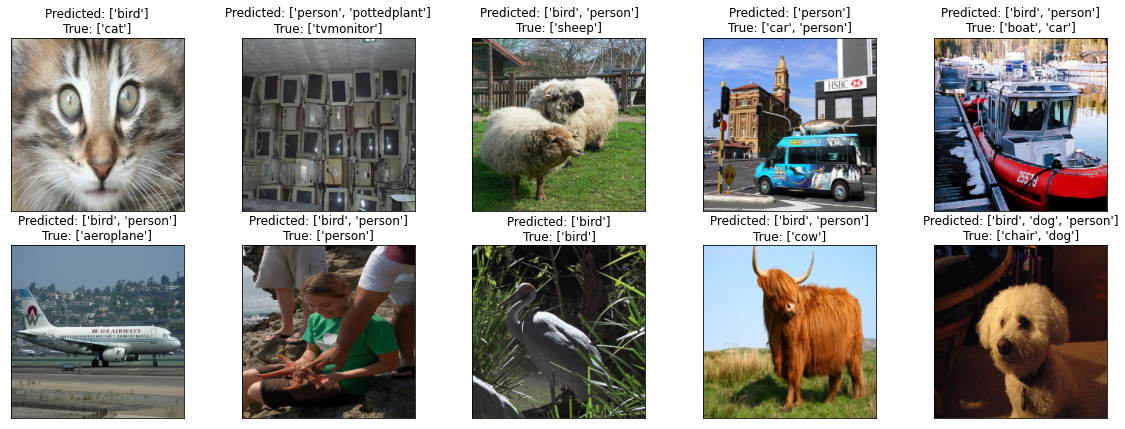

In [175]:
fig=plt.figure(figsize=(20, 7))
for i in range(1,6):
  idx = random.randint(0,len(x_train))
  fig.add_subplot(2, 5, i)
  plt.imshow(x_train[idx])
  y_pred = one_hot_decode(np.around(model(x_train[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_train[idx])))
  plt.xticks([])
  plt.yticks([])
for i in range(6,11):
  idx = random.randint(0,len(x_val))
  fig.add_subplot(2, 5, i)
  plt.imshow(x_val[idx])
  y_pred = one_hot_decode(np.around(model(x_val[idx:idx+1])[0]).astype('int'))
  plt.title('Predicted: {}\nTrue: {}'.format(y_pred, one_hot_decode(y_val[idx])))
  plt.xticks([])
  plt.yticks([])